In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
#import scipy.spatial.distance as spat_dist
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
#import sklearn.metrics.pairwise as pairwise
#import sklearn.feature_selection as features
#import statsmodels.stats.multitest as multitest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.impute import KNNImputer
#from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
#from imblearn.over_sampling import SMOTENC
#from sklearn.preprocessing import LabelEncoder

In [ ]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CES19_data = pd.read_csv('/content/drive/My Drive/GLO-7027/CES19.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (25,27,28,30,31,33,34,39,179,181,188,192,193,199,210,227,234,236,237,239,240,243,276,299,302,311,314,315,316,327,362,417,418,421,422,423,424,425,431,464,465,468,538,541,578,579,582,583,584) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 1) Préparation des données

In [ ]:
CES19_converted = CES19_data.infer_objects()

Reprenons d'abord le dataframe initial et retirons toutes les colonnes du PES19

In [ ]:
data_ces_only = CES19_converted.copy()
data_ces_only = data_ces_only.loc[:,~data_ces_only.columns.str.startswith('pes19')].copy()

Comme précédemment, retirons toutes les colonnes dont des réponses ont été volontairement masquées:

In [ ]:
list_todel = ['cps19_votechoice', 'cps19_votechoice_pr', 'cps19_vote_unlikely', 'cps19_vote_unlike_pr', 'cps19_v_advance', 
              'cps19_votechoice_7_TEXT', 'cps19_votechoice_pr_7_TEXT', 'cps19_vote_unlikely_7_TEXT', 'cps19_vote_unlike_pr_7_TEXT',
              'cps19_v_advance_7_TEXT', 'cps19_vote_lean', 'cps19_vote_lean_7_TEXT', 'cps19_vote_lean_pr', 'cps19_vote_lean_pr_7_TEXT',
              'cps19_2nd_choice', 'cps19_2nd_choice_7_TEXT', 'cps19_2nd_choice_pr', 'cps19_2nd_choice_pr_7_TEXT', 'cps19_not_vote_for_1', 
              'cps19_not_vote_for_2', 'cps19_not_vote_for_3', 'cps19_not_vote_for_4', 'cps19_not_vote_for_5', 'cps19_not_vote_for_6', 
              'cps19_not_vote_for_7', 'cps19_not_vote_for_8', 'cps19_not_vote_for_9', 'cps19_not_vote_for_7_TEXT']

# Une variété de colonnes de metadata sont aussi retirées
list_meta = ['cps19_weight_general_all', 'cps19_weight_general_restricted', 
             'cps19_duplicates_flag', 'get_news', 'get_more_naming',
             'get_not_vote_for', 'get_party_issue_handling', 'get_imp_loc_iss',
             'get_outcome', 'justice_law', 'justice_law_fr', 'lr_scale_order', 
             'ethnicity_intro', 'ethnicity_intro_fr', 'premier', 'province_fr',
             'pid_en', 'pid_party_en', 'pid_party_fr', 'confidence_institutions_word',
             'confidence_institutions_word_fr', 'govt_programs_word', 
             'govt_programs_word_fr', 'split_taxes', 'split_senate', 'split_trade',
             'split_lifesat', 'split_responsibility', 'split_sexism', 
             'split_abortion', 'split_getahead', 'split_att_div', 'split_govt_eff',
             'split_medical', 'split_ties', 'split_health_followups',
             'split_gender_id', 'split_big5', 'split_hatespeech', 'split_vol_assoc',
             'notvote_split', 'splitsample', 'constituencyname', 'pes10_socnet3']
             # La dernière colonne est une question du pes

In [ ]:
# Intentions de vote que l'on cherche à prédire

to_pred = pd.read_table('/content/drive/My Drive/GLO-7027/exemple_GLO.txt',
                        header=None, index_col=0)

Les intentions de vote que l'on cherche à prédire sont d'abord retirées:

In [ ]:
data_ready = data_ces_only.drop(labels=to_pred.index, axis=0)

Puis, les cinq colonnes d'intentions de vote sont combinées en une seule (qui gardera le nom vote_choice):

In [ ]:
votes = data_ready[["cps19_votechoice", "cps19_votechoice_pr", "cps19_vote_unlikely", "cps19_vote_unlike_pr", "cps19_v_advance"]]
votes = votes.fillna('').sum(axis=1)
data_ready['cps19_votechoice'] = votes

In [ ]:
# Certaines rangées ne contenaient aucune intention de vote. La chaîne vide est
# replacée par un NaN et ces données sont retirées
data_ready['cps19_votechoice'] = np.where(data_ready['cps19_votechoice'] == '', np.NaN, data_ready['cps19_votechoice'])
data_ready = data_ready.dropna(subset=['cps19_votechoice'])

In [ ]:
vote_int = data_ready[list_todel]

In [ ]:
data_todel = list_todel + list_meta
data_ready= data_ready.drop(labels=data_todel, axis=1)
# Les IDs et les dates sont retirés pour l'instant
data_ready = data_ready.drop(labels=['Unnamed: 0', 'cps19_consent',
                                     'cps19_StartDate', 'cps19_EndDate',
                                     'cps19_ResponseId'], axis=1)

In [ ]:
# Les données textuelles et numériques sont séparées
num_cols = np.where(data_ready.dtypes != 'object')
data_num = data_ready.iloc[:, np.r_[num_cols]]

text_cols = np.where(data_ready.dtypes == 'object')
data_text = data_ready.iloc[:, np.r_[text_cols]]

In [ ]:
# Des données numériques qui ne sont pas utiles sont retirées
num_not = ['cps19_current_date', 'cps19_current_date_string',
           'cps19_Q_TotalDuration', 'cps19_data_quality', 'cps19_inattentive', 
           'constituencynumber']
data_num = data_num.drop(labels=num_not, axis=1)

# La data a laquelle le sondage a été rempli pourrait très bien être utile!!

Dataframe des one-hot vectors:

In [ ]:
data_text_NaN = data_text.fillna('NaN')
uniques = data_text_NaN.nunique()

In [ ]:
one_hot = np.where(uniques == 2)
one_hot_df = data_text_NaN.iloc[:, np.r_[one_hot]]

In [ ]:
one_hot_df = one_hot_df.drop(labels=['cps19_Q_Language'], axis=1)

one_hot_df.iloc[:, :] = np.where(one_hot_df.iloc[:, :] == 'NaN', 0, 1) 

## 2) Entraînements d'arbres de décision:

Faisons un premier modèle simple :

In [ ]:
cat_tokeep = data_text[['cps19_imp_iss_party', 'cps19_fed_id', 
                        'cps19_vote_2015']].copy()

cat_tokeep = pd.get_dummies(cat_tokeep)

cats_first = pd.concat([cat_tokeep, vote_int['cps19_votechoice']], axis=1)

cats_first = cats_first.dropna()

In [ ]:
feats_first = cats_first.drop('cps19_votechoice', axis=1)
labels_first = cats_first['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
train_features, valid_features, train_labels, valid_labels = train_test_split(feats_first, labels_first, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels, test_size = (2/9), random_state = 42)

Entraînement d'un arbre:

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
#scoring = ['f1_weighted', 'balanced_accuracy']
#cv = KFold(n_splits=10)

#scores = cross_validate(Tree, train_features, train_labels, cv=10,
                        #scoring=scoring)

Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

In [ ]:
#scores

Performance sur les données de test:

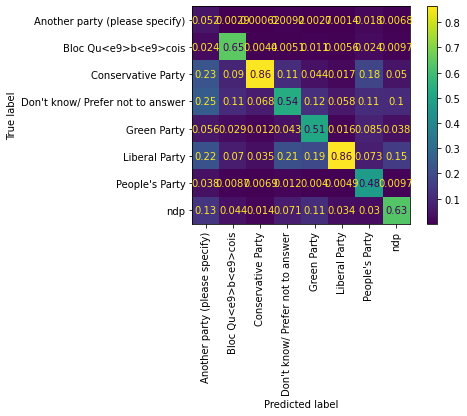

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.05      0.38      0.09        40
            Bloc Qu<e9>b<e9>cois       0.65      0.82      0.72       271
              Conservative Party       0.86      0.80      0.83      1721
Don't know/ Prefer not to answer       0.54      0.51      0.52      1042
                     Green Party       0.51      0.70      0.59       548
                   Liberal Party       0.86      0.65      0.74      1896
                  People's Party       0.48      0.58      0.52       136
                             ndp       0.63      0.70      0.66       934

                        accuracy                           0.68      6588
                       macro avg       0.57      0.64      0.59      6588
                    weighted avg       0.73      0.68      0.70      6588



Essayons d'ajouter le préférence pour un parti au provincial:

In [ ]:
prov_party = data_text['cps19_prov_id'].copy()

prov_party = pd.get_dummies(prov_party)

cats_second = pd.concat([cats_first, prov_party], axis=1)

cats_second = cats_second.dropna()

In [ ]:
feats_second = cats_second.drop('cps19_votechoice', axis=1)
labels_second = cats_second['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_second, labels_second, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6856201464592555
Accuracy_balanced =  0.6856201464592555


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

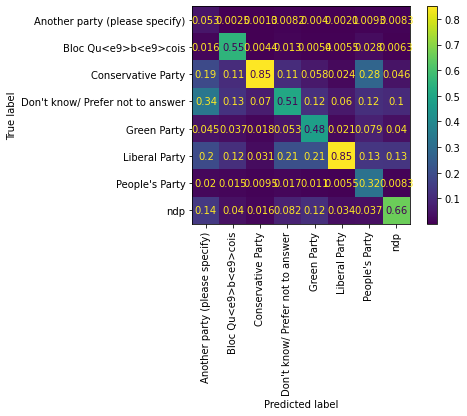

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.05      0.33      0.09        40
            Bloc Qu<e9>b<e9>cois       0.55      0.82      0.66       271
              Conservative Party       0.85      0.78      0.81      1721
Don't know/ Prefer not to answer       0.51      0.48      0.49      1042
                     Green Party       0.48      0.65      0.55       548
                   Liberal Party       0.85      0.65      0.74      1896
                  People's Party       0.32      0.51      0.39       136
                             ndp       0.66      0.68      0.67       934

                        accuracy                           0.66      6588
                       macro avg       0.53      0.61      0.55      6588
                    weighted avg       0.71      0.66      0.68      6588



Ceci a empiré le modèle...

Essayons d'ajouter la satisfactions envers le gouvernement sortant:

In [ ]:
data_text['cps19_fed_gov_sat'].unique()

array(['Not very satisfied', 'Fairly satisfied', 'Not at all satisfied',
       "Don't know/ Prefer not to answer", 'Very satisfied'], dtype=object)

In [ ]:
gov_sat = data_text['cps19_fed_gov_sat'].copy()

gov_sat = pd.get_dummies(gov_sat)

cats_third = pd.concat([cats_first, gov_sat], axis=1)

cats_third = cats_third.dropna()

In [ ]:
feats_third = cats_third.drop('cps19_votechoice', axis=1)
labels_third = cats_third['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_third, labels_third, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.706623312479934
Accuracy_balanced =  0.706623312479934


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

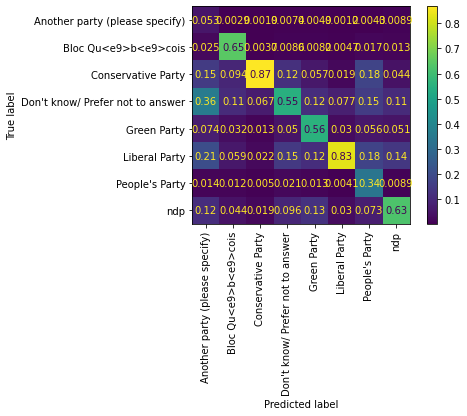

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.05      0.38      0.09        40
            Bloc Qu<e9>b<e9>cois       0.65      0.82      0.72       271
              Conservative Party       0.87      0.81      0.84      1721
Don't know/ Prefer not to answer       0.55      0.43      0.48      1042
                     Green Party       0.56      0.62      0.59       548
                   Liberal Party       0.83      0.74      0.79      1896
                  People's Party       0.34      0.58      0.43       136
                             ndp       0.63      0.68      0.65       934

                        accuracy                           0.69      6588
                       macro avg       0.56      0.63      0.57      6588
                    weighted avg       0.72      0.69      0.70      6588



Ceci n'a pas vraiment amélioré le modèle non plus... **Il y a une légère amélioration d'après la cross-validation**

Ajoutons la série "leader cares":

In [ ]:
mask_model = one_hot_df.columns.str.contains(r'cps19_lead_cares*')
data_cares = one_hot_df.loc[:, mask_model]

In [ ]:
data_fourth = pd.concat([cats_first, data_cares], axis=1)

data_fourth = data_fourth.dropna()

In [ ]:
feats_fourth = data_fourth.drop('cps19_votechoice', axis=1)
labels_fourth = data_fourth['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_fourth, labels_fourth, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6939115410990808
Accuracy_balanced =  0.6939115410990808


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

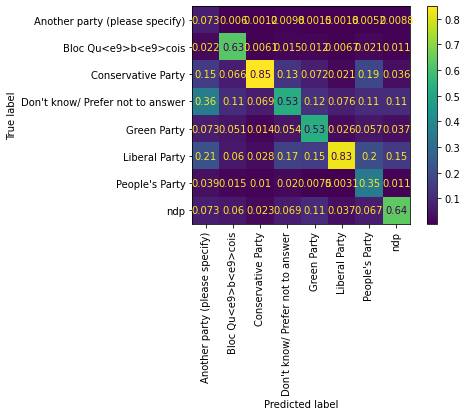

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.07      0.33      0.12        40
            Bloc Qu<e9>b<e9>cois       0.63      0.77      0.69       271
              Conservative Party       0.85      0.81      0.83      1721
Don't know/ Prefer not to answer       0.53      0.47      0.50      1042
                     Green Party       0.53      0.64      0.58       548
                   Liberal Party       0.83      0.71      0.77      1896
                  People's Party       0.35      0.50      0.41       136
                             ndp       0.64      0.70      0.67       934

                        accuracy                           0.69      6588
                       macro avg       0.55      0.62      0.57      6588
                    weighted avg       0.71      0.69      0.70      6588



**Moins bon que la version précédente, d'après la cross-validation**

Toujours pas d'amélioration... Et si on combine tous les attributs qui ont été ajoutés?

In [ ]:
data_fifth = pd.concat([cats_first, prov_party, gov_sat, data_cares], axis=1)

data_fifth = data_fifth.dropna()

In [ ]:
feats_fifth = data_fifth.drop('cps19_votechoice', axis=1)
labels_fifth = data_fifth['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_fifth, labels_fifth, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6734158183259054
Accuracy_balanced =  0.6734158183259054


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

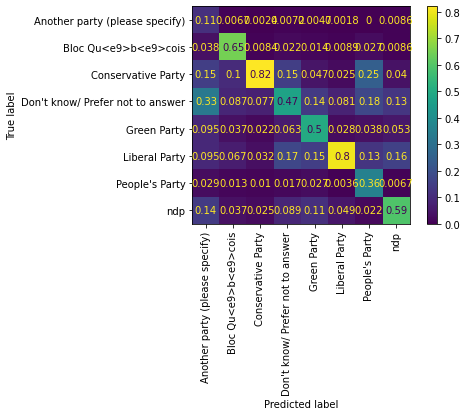

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.11      0.30      0.17        40
            Bloc Qu<e9>b<e9>cois       0.65      0.72      0.68       271
              Conservative Party       0.82      0.79      0.81      1721
Don't know/ Prefer not to answer       0.47      0.44      0.46      1042
                     Green Party       0.50      0.58      0.54       548
                   Liberal Party       0.80      0.72      0.76      1896
                  People's Party       0.36      0.49      0.42       136
                             ndp       0.59      0.67      0.63       934

                        accuracy                           0.67      6588
                       macro avg       0.54      0.59      0.56      6588
                    weighted avg       0.68      0.67      0.67      6588



Il n'y a toujours pas d'amélioration. Cela confirme l'utilité limité de ces attributs.

**Encore pire que l'ajout de la satisfaction envers le gouvernement sortant, d'après la cross-validation**

Ajoutons des attributs permettant d'identifier les Québécois francophones:

In [ ]:
data_qc = one_hot_df[['cps19_ethnicity_38', 'cps19_language_69']].copy()

data_sixth = pd.concat([cats_first, data_qc], axis=1)
data_sixth = data_sixth.dropna()

In [ ]:
feats_sixth = data_sixth.drop('cps19_votechoice', axis=1)
labels_sixth = data_sixth['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_sixth, labels_sixth, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6926092265877266
Accuracy_balanced =  0.6926092265877266


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

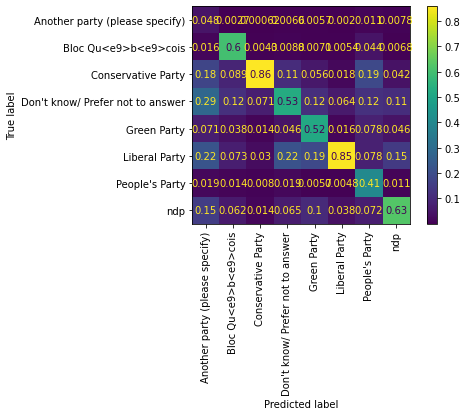

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.05      0.38      0.09        40
            Bloc Qu<e9>b<e9>cois       0.60      0.82      0.70       271
              Conservative Party       0.86      0.81      0.83      1721
Don't know/ Prefer not to answer       0.53      0.46      0.49      1042
                     Green Party       0.52      0.66      0.58       548
                   Liberal Party       0.85      0.66      0.74      1896
                  People's Party       0.41      0.54      0.46       136
                             ndp       0.63      0.69      0.66       934

                        accuracy                           0.67      6588
                       macro avg       0.56      0.63      0.57      6588
                    weighted avg       0.72      0.67      0.69      6588



Cela semble à peine aider... Et si on ajoute les autres attributs un à la fois?

In [ ]:
data_sixth_a = pd.concat([data_sixth, prov_party], axis=1)
data_sixth_a = data_sixth_a.dropna()

feats_sixth_a = data_sixth_a.drop('cps19_votechoice', axis=1)
labels_sixth_a = data_sixth_a['cps19_votechoice']

# On met de côté 10% des données pour la validation
train_features, valid_features, train_labels, valid_labels = train_test_split(feats_sixth_a, labels_sixth_a, test_size = 0.1, random_state = 42)

# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels, test_size = (2/9), random_state = 42)

Tree = DecisionTreeClassifier(class_weight='balanced')

Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.06      0.25      0.09        40
            Bloc Qu<e9>b<e9>cois       0.57      0.79      0.66       271
              Conservative Party       0.84      0.79      0.82      1721
Don't know/ Prefer not to answer       0.53      0.45      0.48      1042
                     Green Party       0.50      0.61      0.55       548
                   Liberal Party       0.81      0.69      0.75      1896
                  People's Party       0.29      0.49      0.37       136
                             ndp       0.63      0.69      0.66       934

                        accuracy                           0.67      6588
                       macro avg       0.53      0.60      0.55      6588
                    weighted avg       0.70      0.67      0.68      6588



In [ ]:
data_sixth_b = pd.concat([data_sixth, gov_sat], axis=1)
data_sixth_b = data_sixth_b.dropna()

feats_sixth_b = data_sixth_b.drop('cps19_votechoice', axis=1)
labels_sixth_b = data_sixth_b['cps19_votechoice']

# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_sixth_b, labels_sixth_b, test_size = 0.1, random_state = 42)

# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

Tree = DecisionTreeClassifier(class_weight='balanced')

Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

10-fold cross-validation (pour comparer), car cet attribut semblait utile:

In [ ]:
#Évaluation par cross-validation:
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6942915120094674
Accuracy_balanced =  0.6942915120094674


In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.05      0.28      0.09        40
            Bloc Qu<e9>b<e9>cois       0.57      0.78      0.66       271
              Conservative Party       0.87      0.80      0.83      1721
Don't know/ Prefer not to answer       0.52      0.43      0.47      1042
                     Green Party       0.50      0.62      0.55       548
                   Liberal Party       0.84      0.72      0.78      1896
                  People's Party       0.32      0.55      0.40       136
                             ndp       0.62      0.67      0.64       934

                        accuracy                           0.68      6588
                       macro avg       0.54      0.61      0.55      6588
                    weighted avg       0.71      0.68      0.69      6588



In [ ]:
data_sixth_c = pd.concat([data_sixth, data_cares], axis=1)
data_sixth_c = data_sixth_c.dropna()

feats_sixth_c = data_sixth_c.drop('cps19_votechoice', axis=1)
labels_sixth_c = data_sixth_c['cps19_votechoice']

# On met de côté 10% des données pour la validation
train_features, valid_features, train_labels, valid_labels = train_test_split(feats_sixth_c, labels_sixth_c, test_size = 0.1, random_state = 42)

# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels, test_size = (2/9), random_state = 42)

Tree = DecisionTreeClassifier(class_weight='balanced')

Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.06      0.23      0.09        40
            Bloc Qu<e9>b<e9>cois       0.63      0.72      0.67       271
              Conservative Party       0.84      0.81      0.82      1721
Don't know/ Prefer not to answer       0.51      0.45      0.48      1042
                     Green Party       0.49      0.61      0.55       548
                   Liberal Party       0.82      0.73      0.77      1896
                  People's Party       0.34      0.48      0.40       136
                             ndp       0.63      0.67      0.65       934

                        accuracy                           0.68      6588
                       macro avg       0.54      0.59      0.55      6588
                    weighted avg       0.70      0.68      0.69      6588



On n'améliore toujours pas les prédictions...

Et si on ajoutait la série d'attributs numériques qui semble être la meilleure, soit 'party_rating'?

In [ ]:
mask_model = data_num.columns.str.contains(r'cps19_party_rating*')
data_party = data_num.loc[:, mask_model]

data_seventh = pd.concat([cats_first, data_party], axis=1)
data_seventh = data_seventh.dropna()

feats_seventh = data_seventh.drop('cps19_votechoice', axis=1)
labels_seventh = data_seventh['cps19_votechoice']

In [ ]:
# Scaling min-max des données numériques:
scaler = MinMaxScaler()
feats_seventh = pd.DataFrame(scaler.fit_transform(feats_seventh), 
                             columns = feats_seventh.columns)

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_seventh, labels_seventh, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6878189823544049
Accuracy_balanced =  0.6878189823544049


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

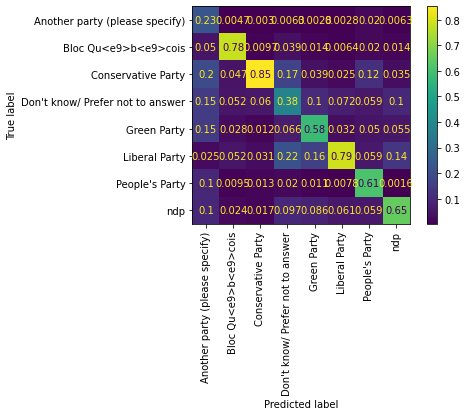

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.23      0.31      0.26        29
            Bloc Qu<e9>b<e9>cois       0.78      0.72      0.75       230
              Conservative Party       0.85      0.84      0.85      1356
Don't know/ Prefer not to answer       0.38      0.44      0.41       549
                     Green Party       0.58      0.57      0.58       365
                   Liberal Party       0.79      0.77      0.78      1465
                  People's Party       0.61      0.54      0.58       114
                             ndp       0.65      0.65      0.65       628

                        accuracy                           0.71      4736
                       macro avg       0.61      0.61      0.61      4736
                    weighted avg       0.72      0.71      0.71      4736



On a bien amélioré le modèle. D'après la cross-validation, la performance est cependant moindre que lorsque la satisfaction envers le gouvernement sortant avait été ajoutée.

Essayons de l'ajouter:

In [ ]:
data_8 = pd.concat([data_seventh, gov_sat], axis=1)

data_8 = data_8.dropna()

feats_8 = data_8.drop('cps19_votechoice', axis=1)
labels_8 = data_8['cps19_votechoice']

In [ ]:
# Scaling min-max des données numériques:
feats_8 = pd.DataFrame(scaler.fit_transform(feats_8), columns = feats_8.columns)

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_8, labels_8, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6890088958315056
Accuracy_balanced =  0.6890088958315056


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

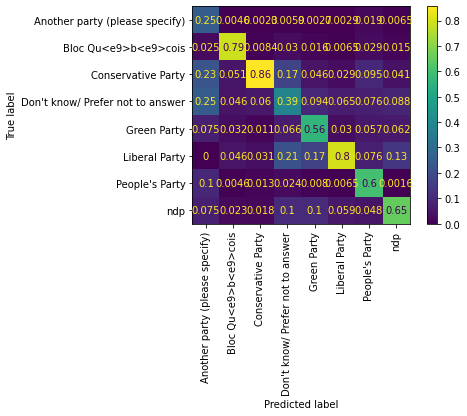

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.25      0.34      0.29        29
            Bloc Qu<e9>b<e9>cois       0.79      0.74      0.77       230
              Conservative Party       0.86      0.83      0.84      1356
Don't know/ Prefer not to answer       0.39      0.48      0.43       549
                     Green Party       0.56      0.58      0.57       365
                   Liberal Party       0.80      0.76      0.78      1465
                  People's Party       0.60      0.55      0.58       114
                             ndp       0.65      0.64      0.65       628

                        accuracy                           0.71      4736
                       macro avg       0.61      0.62      0.61      4736
                    weighted avg       0.72      0.71      0.72      4736



On n'améliore pas le modèle. Réintégrons les attributs permettant d'identifier les Québécois francophones:

In [ ]:
data_9 = pd.concat([data_seventh, data_qc], axis=1)
data_9 = data_9.dropna()

feats_9 = data_9.drop('cps19_votechoice', axis=1)
labels_9 = data_9['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_9, labels_9, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6854271703314848
Accuracy_balanced =  0.6854271703314848


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

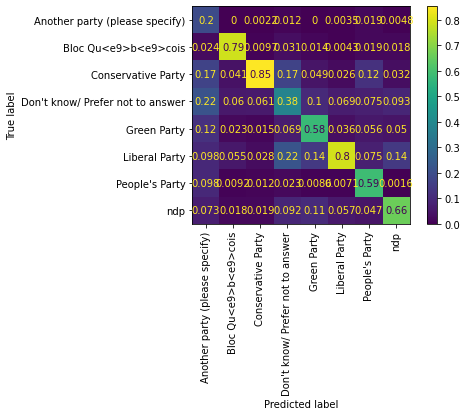

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.20      0.28      0.23        29
            Bloc Qu<e9>b<e9>cois       0.79      0.75      0.77       230
              Conservative Party       0.85      0.84      0.85      1356
Don't know/ Prefer not to answer       0.38      0.45      0.41       549
                     Green Party       0.58      0.55      0.57       365
                   Liberal Party       0.80      0.77      0.78      1465
                  People's Party       0.59      0.55      0.57       114
                             ndp       0.66      0.66      0.66       628

                        accuracy                           0.71      4736
                       macro avg       0.61      0.61      0.60      4736
                    weighted avg       0.72      0.71      0.72      4736



On n'améliore pas vraiment le modèle...

Est-ce que la combinaison de la satisfaction et des attributs identifiant les Québécois est meilleure?

In [ ]:
data_10 = pd.concat([data_seventh, gov_sat, data_qc], axis=1)
data_10 = data_10.dropna()

feats_10 = data_10.drop('cps19_votechoice', axis=1)
labels_10 = data_10['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_10, labels_10, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6897511806624952
Accuracy_balanced =  0.6897511806624952


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

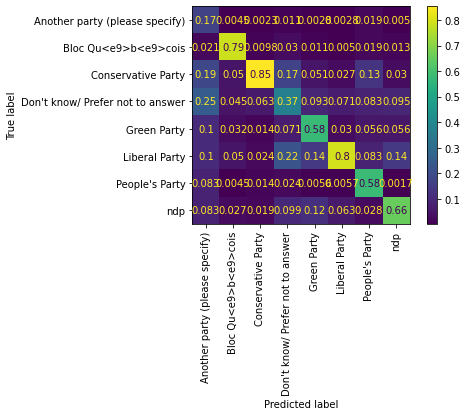

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.17      0.28      0.21        29
            Bloc Qu<e9>b<e9>cois       0.79      0.76      0.77       230
              Conservative Party       0.85      0.84      0.85      1356
Don't know/ Prefer not to answer       0.37      0.44      0.40       549
                     Green Party       0.58      0.56      0.57       365
                   Liberal Party       0.80      0.77      0.78      1465
                  People's Party       0.58      0.55      0.57       114
                             ndp       0.66      0.63      0.64       628

                        accuracy                           0.71      4736
                       macro avg       0.60      0.60      0.60      4736
                    weighted avg       0.72      0.71      0.71      4736



Le modèle semble être très légèrement supérieur, mais est-ce que le gain en vaut l'augmentation de complexité?

Il faut améliorer la performance pour les partis "mineurs". Est-ce la série "leader strong" serait utile?

In [ ]:
mask_model = one_hot_df.columns.str.contains(r'cps19_lead_strong*')
data_strong = one_hot_df.loc[:, mask_model]

In [ ]:
data_11 = pd.concat([data_seventh, gov_sat, data_qc, data_strong], axis=1)
data_11 = data_11.dropna()

feats_11 = data_11.drop('cps19_votechoice', axis=1)
labels_11 = data_11['cps19_votechoice']

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_11, labels_11, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6876019212105124
Accuracy_balanced =  0.6876019212105124


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

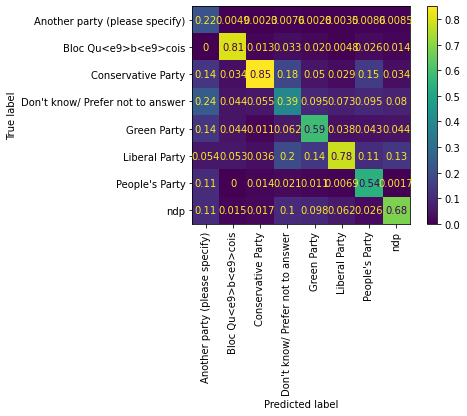

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.22      0.28      0.24        29
            Bloc Qu<e9>b<e9>cois       0.81      0.72      0.76       230
              Conservative Party       0.85      0.83      0.84      1356
Don't know/ Prefer not to answer       0.39      0.47      0.43       549
                     Green Party       0.59      0.57      0.58       365
                   Liberal Party       0.78      0.77      0.78      1465
                  People's Party       0.54      0.55      0.55       114
                             ndp       0.68      0.64      0.66       628

                        accuracy                           0.71      4736
                       macro avg       0.61      0.61      0.61      4736
                    weighted avg       0.72      0.71      0.72      4736



Cela n'améliore pas le modèle...

Essayons maintenant d'ajouter l'âge des électeurs et l'intérêt envers l'élection:

In [ ]:
data_age = data_num[['cps19_age', 'cps19_interest_elxn_1']].copy()
data_12 = pd.concat([data_seventh, gov_sat, data_qc, data_age], axis=1)
data_12 = data_12.dropna()

feats_12 = data_12.drop('cps19_votechoice', axis=1)
labels_12 = data_12['cps19_votechoice']

# Scaling min-max des données numériques:
feats_12 = pd.DataFrame(scaler.fit_transform(feats_12), 
                        columns = feats_12.columns)

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_12, labels_12, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6901493893355598
Accuracy_balanced =  0.6901493893355598


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

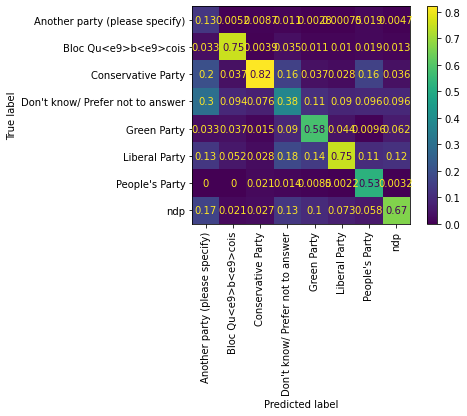

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.13      0.13      0.13        30
            Bloc Qu<e9>b<e9>cois       0.75      0.72      0.74       200
              Conservative Party       0.82      0.84      0.83      1248
Don't know/ Prefer not to answer       0.38      0.40      0.39       591
                     Green Party       0.58      0.53      0.55       387
                   Liberal Party       0.75      0.77      0.76      1307
                  People's Party       0.53      0.56      0.54        99
                             ndp       0.67      0.61      0.64       689

                        accuracy                           0.68      4551
                       macro avg       0.58      0.57      0.57      4551
                    weighted avg       0.69      0.68      0.68      4551



Cela empire le modèle...

Essayons de remplacer les attributs identifiant les Québécois par la province d'origine des électeurs:

In [ ]:
data_province = pd.get_dummies(data_text['cps19_province'])

data_13 = pd.concat([data_seventh, gov_sat, data_province], axis=1)
data_13 = data_13.dropna()

feats_13 = data_13.drop('cps19_votechoice', axis=1)
labels_13 = data_13['cps19_votechoice']

# Scaling min-max des données numériques:
feats_13 = pd.DataFrame(scaler.fit_transform(feats_13), 
                        columns = feats_13.columns)

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_13, labels_13, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6901487622010627
Accuracy_balanced =  0.6901487622010627


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

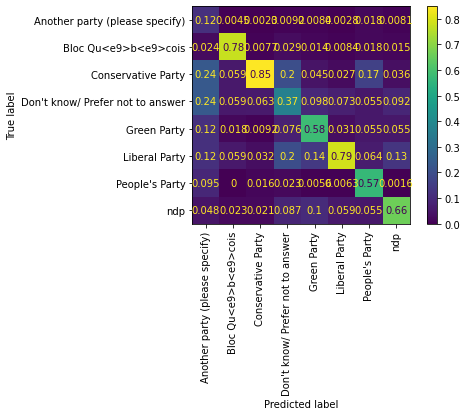

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.12      0.17      0.14        29
            Bloc Qu<e9>b<e9>cois       0.78      0.75      0.76       230
              Conservative Party       0.85      0.81      0.83      1356
Don't know/ Prefer not to answer       0.37      0.44      0.40       549
                     Green Party       0.58      0.57      0.58       365
                   Liberal Party       0.79      0.77      0.78      1465
                  People's Party       0.57      0.54      0.56       114
                             ndp       0.66      0.65      0.66       628

                        accuracy                           0.71      4736
                       macro avg       0.59      0.59      0.59      4736
                    weighted avg       0.72      0.71      0.71      4736



Cela n'améliore pas le modèle. Essayons de conserver seulement les provinces Québec, Ontario, Alberta et Colombie-Britannique:

In [ ]:
data_14 = pd.concat([data_seventh, gov_sat, data_province[['Quebec', 'Ontario',
                                                           'Alberta', 'British Columbia']]], axis=1)
data_14 = data_14.dropna()

feats_14 = data_14.drop('cps19_votechoice', axis=1)
labels_14 = data_14['cps19_votechoice']

# Scaling min-max des données numériques:
feats_14 = pd.DataFrame(scaler.fit_transform(feats_14), 
                        columns = feats_14.columns)

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_14, labels_14, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6903555490567873
Accuracy_balanced =  0.6903555490567873


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

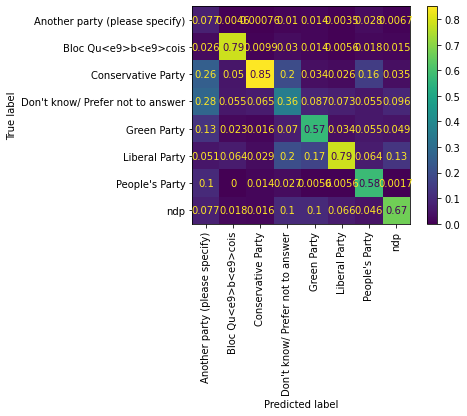

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.08      0.10      0.09        29
            Bloc Qu<e9>b<e9>cois       0.79      0.75      0.77       230
              Conservative Party       0.85      0.82      0.84      1356
Don't know/ Prefer not to answer       0.36      0.44      0.40       549
                     Green Party       0.57      0.56      0.56       365
                   Liberal Party       0.79      0.77      0.78      1465
                  People's Party       0.58      0.55      0.57       114
                             ndp       0.67      0.63      0.65       628

                        accuracy                           0.70      4736
                       macro avg       0.58      0.58      0.58      4736
                    weighted avg       0.71      0.70      0.71      4736



Cela n'est pas très bon...

Dernière tentative avec Québec, Alberta et Saskatchewan:

In [ ]:
data_15 = pd.concat([data_seventh, gov_sat, data_province[['Quebec', 'Alberta',
                                                           'Saskatchewan']]], 
                    axis=1)
                    
data_15 = data_15.dropna()

feats_15 = data_15.drop('cps19_votechoice', axis=1)
labels_15 = data_15['cps19_votechoice']

# Scaling min-max des données numériques:
feats_15 = pd.DataFrame(scaler.fit_transform(feats_15), 
                        columns = feats_15.columns)

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_15, labels_15, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
#Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=10,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6881515536407911
Accuracy_balanced =  0.6881515536407911


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

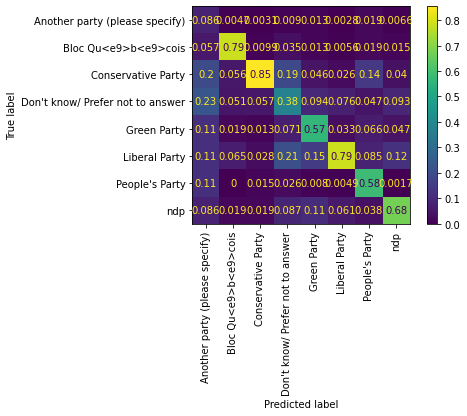

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.09      0.10      0.09        29
            Bloc Qu<e9>b<e9>cois       0.79      0.73      0.76       230
              Conservative Party       0.85      0.83      0.84      1356
Don't know/ Prefer not to answer       0.38      0.46      0.41       549
                     Green Party       0.57      0.58      0.57       365
                   Liberal Party       0.79      0.77      0.78      1465
                  People's Party       0.58      0.54      0.56       114
                             ndp       0.68      0.65      0.66       628

                        accuracy                           0.71      4736
                       macro avg       0.59      0.58      0.59      4736
                    weighted avg       0.72      0.71      0.71      4736



On ne rejoint toujours pas la performance du meilleur modèle.

Qu'en est-il des attributs choisis arbitrairement pour obtenir le meilleur modèle dans la version précédente du script?

In [ ]:
### Copié du script Training

mask_model = one_hot_df.columns.str.contains(r'cps19_lead_trust*')
data_model = one_hot_df.loc[:, mask_model]
data_model = pd.concat([data_model, one_hot_df[['cps19_ethnicity_38',
                                                'cps19_language_69',
                                                'cps19_party_member_38']]], axis=1)


In [ ]:
### Copié du script Training

# 1- Sélection données numériques

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_lead_rating*|cps19_cand_rating*')
#mask_model = data_num.columns.str.contains(r'cps19_lead_rating')
data_tree = data_num.loc[:, mask_model]

data_tree = pd.concat([data_tree, data_num[['cps19_age', 
                                           'cps19_interest_elxn_1']]], axis=1)

# 2- Ajout des données one-hot et catégoriques
data_tree = pd.concat([data_tree, data_model], axis=1)

cat_tokeep = data_text[['cps19_imp_iss_party', 'cps19_fed_id', 
                        'cps19_vote_2015']].copy()

#cat_tokeep = cat_tokeep.dropna()
cat_tokeep = pd.get_dummies(cat_tokeep)

data_tree = pd.concat([data_tree, cat_tokeep], axis=1)
data_tree = pd.concat([data_tree, vote_int['cps19_votechoice']], axis=1)

data_tree = data_tree.drop('cps19_cand_rating_26', axis=1)
data_tree = data_tree.dropna()

In [ ]:
feats_16 = data_tree.drop('cps19_votechoice', axis=1)
labels_16 = data_tree['cps19_votechoice']

# Scaling min-max des données numériques:
feats_16 = pd.DataFrame(scaler.fit_transform(feats_16), 
                        columns = feats_16.columns)

In [ ]:
# On met de côté 10% des données pour la validation
cv_features, valid_features, cv_labels, valid_labels = train_test_split(feats_16, labels_16, test_size = 0.1, random_state = 42)

In [ ]:
# Puis, on sépare des ensembles de training et de test
train_features, test_features, train_labels, test_labels = train_test_split(cv_features, cv_labels, test_size = (2/9), random_state = 42)

In [ ]:
# Évaluation par cross-validation:
Tree = DecisionTreeClassifier(class_weight='balanced')
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

scores = cross_validate(Tree, cv_features, cv_labels, cv=cv,
                        scoring=scoring)

In [ ]:
F1 = scores['test_f1_weighted'].mean()
accuracy = scores['test_balanced_accuracy'].mean()

print(f'F1_weighted =  {F1}')
print(f'Accuracy_balanced =  {F1}')

F1_weighted =  0.6992821488621305
Accuracy_balanced =  0.6992821488621305


In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

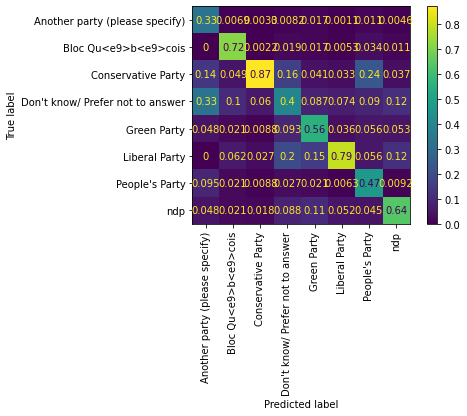

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.33      0.32      0.33        22
            Bloc Qu<e9>b<e9>cois       0.72      0.80      0.75       129
              Conservative Party       0.87      0.84      0.86       941
Don't know/ Prefer not to answer       0.40      0.39      0.40       375
                     Green Party       0.56      0.55      0.55       242
                   Liberal Party       0.79      0.79      0.79       955
                  People's Party       0.47      0.53      0.50        80
                             ndp       0.64      0.68      0.66       412

                        accuracy                           0.72      3156
                       macro avg       0.60      0.61      0.60      3156
                    weighted avg       0.72      0.72      0.72      3156



Les meilleurs arbres de décision ne sont malgré tout pas très performants. À quelle point la performance peut-elle être améliorée en optimisant la profondeur de l'arbre?

Faisons-le d'abord pour le meilleur modèle "minimal" (modèle 7):

Un premier scanning a montré que l'optimum est entre 12 et 20. Le scanning est donc réalisé dans cette zone.

In [ ]:
max_depths = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

tree_perf = pd.DataFrame(columns=['max_depth', 'F1_w_mean', 'F1_w_std',
                                  'b_accuracy_mean', 'b_accuracy_std'])

tree_perf['max_depth'] = max_depths
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

for depth in range(len(max_depths)):
  Tree = DecisionTreeClassifier(class_weight='balanced',
                                max_depth=max_depths[depth])

  scores = cross_validate(Tree, feats_seventh, labels_seventh, cv=cv,
                          scoring=scoring)
  
  F1_mean = scores['test_f1_weighted'].mean()
  F1_std = scores['test_f1_weighted'].std()
  accuracy_mean = scores['test_balanced_accuracy'].mean()
  accuracy_std = scores['test_balanced_accuracy'].std()

  tree_perf.at[depth, 'F1_w_mean'] = F1_mean
  tree_perf.at[depth, 'F1_w_std'] = F1_std
  tree_perf.at[depth, 'b_accuracy_mean'] = accuracy_mean
  tree_perf.at[depth, 'b_accuracy_std'] = accuracy_std

In [ ]:
tree_perf

,max_depth,F1_w_mean,F1_w_std,b_accuracy_mean,b_accuracy_std
0,12,0.707136,0.014125,0.633162,0.021241
1,13,0.720147,0.011258,0.638015,0.021428
2,14,0.720668,0.010205,0.635251,0.018341
3,15,0.71765,0.010259,0.627147,0.019821
4,16,0.719016,0.010689,0.621201,0.014533
5,17,0.719554,0.009956,0.618214,0.013205
6,18,0.713993,0.010754,0.611077,0.015921
7,19,0.711527,0.011049,0.606813,0.01535
8,20,0.708298,0.011699,0.601681,0.013205
9,21,0.708802,0.012314,0.601946,0.016447


L'optimum semble être à 14. Regardons plus en détail la performance du modèle:

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_seventh, labels_seventh, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced', max_depth=14)

In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced', max_depth=14)

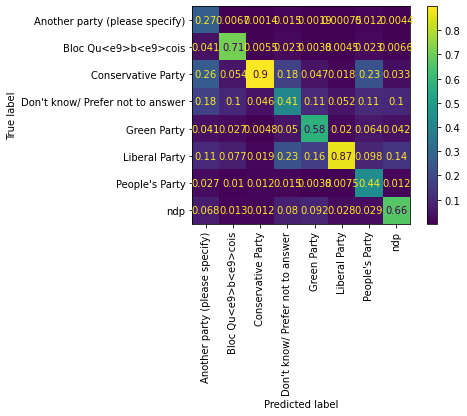

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.27      0.41      0.33        49
            Bloc Qu<e9>b<e9>cois       0.71      0.79      0.75       268
              Conservative Party       0.90      0.78      0.84      1657
Don't know/ Prefer not to answer       0.41      0.58      0.48       827
                     Green Party       0.58      0.67      0.62       459
                   Liberal Party       0.87      0.68      0.76      1711
                  People's Party       0.44      0.55      0.49       138
                             ndp       0.66      0.74      0.70       812

                        accuracy                           0.70      5921
                       macro avg       0.61      0.65      0.62      5921
                    weighted avg       0.74      0.70      0.71      5921



On a quelque peu augmenté le recall par rapport à l'arbre non optimisé.

Répétons la même démarche avec le modèle "arbitraire":

L'optimum est encore une fois entre 12 et 20.

In [ ]:
max_depths = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

tree_perf = pd.DataFrame(columns=['max_depth', 'F1_w_mean', 'F1_w_std',
                                  'b_accuracy_mean', 'b_accuracy_std'])

tree_perf['max_depth'] = max_depths
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

for depth in range(len(max_depths)):
  Tree = DecisionTreeClassifier(class_weight='balanced',
                                max_depth=max_depths[depth])

  scores = cross_validate(Tree, feats_16, labels_16, cv=cv,
                          scoring=scoring)
  
  F1_mean = scores['test_f1_weighted'].mean()
  F1_std = scores['test_f1_weighted'].std()
  accuracy_mean = scores['test_balanced_accuracy'].mean()
  accuracy_std = scores['test_balanced_accuracy'].std()

  tree_perf.at[depth, 'F1_w_mean'] = F1_mean
  tree_perf.at[depth, 'F1_w_std'] = F1_std
  tree_perf.at[depth, 'b_accuracy_mean'] = accuracy_mean
  tree_perf.at[depth, 'b_accuracy_std'] = accuracy_std

In [ ]:
tree_perf

,max_depth,F1_w_mean,F1_w_std,b_accuracy_mean,b_accuracy_std
0,12,0.712058,0.019078,0.638971,0.022101
1,13,0.728017,0.009182,0.64628,0.022268
2,14,0.732004,0.011913,0.647711,0.02489
3,15,0.7298,0.012701,0.638075,0.021883
4,16,0.72525,0.013161,0.625561,0.023881
5,17,0.72111,0.013168,0.621983,0.015012
6,18,0.722826,0.010803,0.617097,0.015811
7,19,0.719494,0.011093,0.611383,0.012636
8,20,0.720111,0.012999,0.604748,0.018425
9,21,0.716327,0.011672,0.600619,0.01874


La profondeur optimale semble encore être de 14.

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_16, labels_16, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced', max_depth=14)

In [ ]:
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced', max_depth=14)

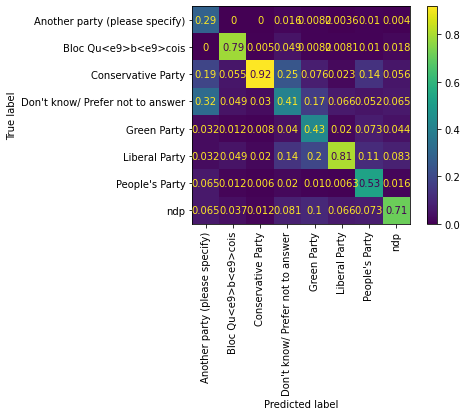

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.29      0.31      0.30        29
            Bloc Qu<e9>b<e9>cois       0.79      0.70      0.74       184
              Conservative Party       0.92      0.78      0.85      1175
Don't know/ Prefer not to answer       0.41      0.48      0.44       467
                     Green Party       0.43      0.71      0.54       293
                   Liberal Party       0.81      0.78      0.79      1154
                  People's Party       0.53      0.55      0.54        92
                             ndp       0.71      0.64      0.68       551

                        accuracy                           0.71      3945
                       macro avg       0.61      0.62      0.61      3945
                    weighted avg       0.74      0.71      0.72      3945



La performance est quelque peu améliorée, mais les arbres restent relativement peu performants. Entraînons des RandomForests sur les mêmes attributs.

Pour le meilleur modèle "minimal", optimisons d'abord le nombre d'estimateurs en postulant une profondeur de 14:

In [ ]:
n_trees = [25, 50, 100, 200, 400, 800] # 1600, 3200, 6400]

forest_perf = pd.DataFrame(columns=['n_trees', 'F1_w_mean', 'F1_w_std',
                                    'b_accuracy_mean', 'b_accuracy_std'])

forest_perf['n_trees'] = n_trees
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

for number in range(len(n_trees)):

  Forest = RandomForestClassifier(max_depth=14, n_estimators=n_trees[number],
                                  class_weight='balanced_subsample')

  scores = cross_validate(Forest, feats_seventh, labels_seventh, cv=cv,
                          scoring=scoring)
  
  F1_mean = scores['test_f1_weighted'].mean()
  F1_std = scores['test_f1_weighted'].std()
  accuracy_mean = scores['test_balanced_accuracy'].mean()
  accuracy_std = scores['test_balanced_accuracy'].std()

  forest_perf.at[number, 'F1_w_mean'] = F1_mean
  forest_perf.at[number, 'F1_w_std'] = F1_std
  forest_perf.at[number, 'b_accuracy_mean'] = accuracy_mean
  forest_perf.at[number, 'b_accuracy_std'] = accuracy_std

In [ ]:
forest_perf

,n_trees,F1_w_mean,F1_w_std,b_accuracy_mean,b_accuracy_std
0,25,0.770737,0.011956,0.687812,0.024093
1,50,0.772712,0.011061,0.691875,0.025853
2,100,0.773873,0.010943,0.692673,0.022409
3,200,0.775811,0.011525,0.694619,0.023012
4,400,0.775605,0.011393,0.695668,0.022785
5,800,0.776337,0.010972,0.695631,0.020961


Il ne semble pas y avoir de gain important en augmentant le nombre d'estimateurs. Validons donc la profondeur maximale en considérant 200 arbres.

In [ ]:
max_depths = [5, 8, 10, 12, 13, 14, 15, 16, 18, 20]

forest_perf = pd.DataFrame(columns=['max_depth', 'F1_w_mean', 'F1_w_std',
                                    'b_accuracy_mean', 'b_accuracy_std'])

forest_perf['max_depth'] = max_depths
scoring = ['f1_weighted', 'balanced_accuracy']
cv = KFold(n_splits=10)

for depth in range(len(max_depths)):

  Forest = RandomForestClassifier(max_depth=max_depths[depth], n_estimators=200,
                                  class_weight='balanced_subsample')

  scores = cross_validate(Forest, feats_seventh, labels_seventh, cv=cv,
                          scoring=scoring)
  
  F1_mean = scores['test_f1_weighted'].mean()
  F1_std = scores['test_f1_weighted'].std()
  accuracy_mean = scores['test_balanced_accuracy'].mean()
  accuracy_std = scores['test_balanced_accuracy'].std()

  forest_perf.at[depth, 'F1_w_mean'] = F1_mean
  forest_perf.at[depth, 'F1_w_std'] = F1_std
  forest_perf.at[depth, 'b_accuracy_mean'] = accuracy_mean
  forest_perf.at[depth, 'b_accuracy_std'] = accuracy_std

In [ ]:
forest_perf

,max_depth,F1_w_mean,F1_w_std,b_accuracy_mean,b_accuracy_std
0,5,0.739218,0.009004,0.684555,0.019707
1,8,0.758868,0.012531,0.704834,0.021642
2,10,0.763047,0.012304,0.706236,0.021294
3,12,0.770128,0.011441,0.701444,0.020245
4,13,0.772094,0.012094,0.69783,0.021748
5,14,0.774497,0.010948,0.694367,0.020441
6,15,0.775905,0.01178,0.687898,0.024486
7,16,0.77904,0.010037,0.686503,0.02227
8,18,0.78034,0.010526,0.680092,0.018927
9,20,0.780375,0.009557,0.669543,0.022389


Le f1-score et l'exactitude varient dans des directions opposées. Essayons de produire des matrices de confusion et rapports de classification pour deux cas: profondeur max de 12 et 18

1) 12

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_seventh, labels_seventh, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                                n_estimators=200)

In [ ]:
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       n_estimators=200)

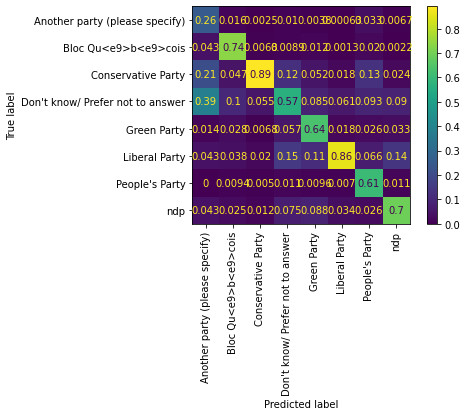

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.26      0.37      0.30        49
            Bloc Qu<e9>b<e9>cois       0.74      0.87      0.80       268
              Conservative Party       0.89      0.87      0.88      1657
Don't know/ Prefer not to answer       0.57      0.54      0.55       827
                     Green Party       0.64      0.72      0.68       459
                   Liberal Party       0.86      0.79      0.83      1711
                  People's Party       0.61      0.67      0.64       138
                             ndp       0.70      0.76      0.73       812

                        accuracy                           0.77      5921
                       macro avg       0.66      0.70      0.67      5921
                    weighted avg       0.77      0.77      0.77      5921



2) 18

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                                n_estimators=200)

In [ ]:
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       n_estimators=200)

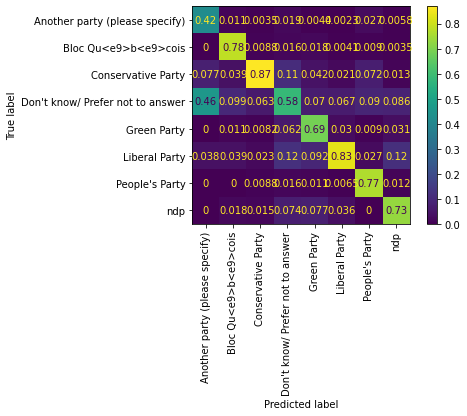

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.42      0.22      0.29        49
            Bloc Qu<e9>b<e9>cois       0.78      0.83      0.81       268
              Conservative Party       0.87      0.90      0.88      1657
Don't know/ Prefer not to answer       0.58      0.54      0.56       827
                     Green Party       0.69      0.68      0.69       459
                   Liberal Party       0.83      0.83      0.83      1711
                  People's Party       0.77      0.62      0.68       138
                             ndp       0.73      0.77      0.75       812

                        accuracy                           0.78      5921
                       macro avg       0.71      0.67      0.69      5921
                    weighted avg       0.78      0.78      0.78      5921



Il semble toujours préférable d'augmenter la profondeur maximale. Poussons cela à l'extrême:

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample', max_depth=31,
                                n_estimators=200)

In [ ]:
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=31,
                       n_estimators=200)

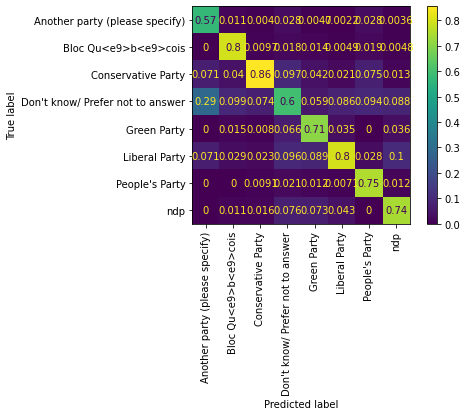

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.57      0.16      0.25        49
            Bloc Qu<e9>b<e9>cois       0.80      0.81      0.80       268
              Conservative Party       0.86      0.91      0.88      1657
Don't know/ Prefer not to answer       0.60      0.48      0.53       827
                     Green Party       0.71      0.66      0.68       459
                   Liberal Party       0.80      0.86      0.83      1711
                  People's Party       0.75      0.58      0.66       138
                             ndp       0.74      0.76      0.75       812

                        accuracy                           0.78      5921
                       macro avg       0.73      0.65      0.67      5921
                    weighted avg       0.77      0.78      0.77      5921



On semble obtenir la meilleure performance pour une profondeur maximale de 31!

En fait, le recall diminue pour les classes minoritaires...

Prenons maintenant le modèle "arbitraire", avec les mêmes paramètres:

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_16, labels_16, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                                n_estimators=200)

In [ ]:
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       n_estimators=200)

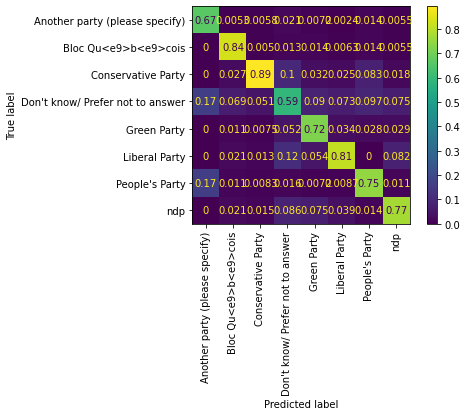

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.67      0.14      0.23        29
            Bloc Qu<e9>b<e9>cois       0.84      0.85      0.84       184
              Conservative Party       0.89      0.91      0.90      1175
Don't know/ Prefer not to answer       0.59      0.49      0.53       467
                     Green Party       0.72      0.69      0.70       293
                   Liberal Party       0.81      0.89      0.85      1154
                  People's Party       0.75      0.59      0.66        92
                             ndp       0.77      0.77      0.77       551

                        accuracy                           0.80      3945
                       macro avg       0.76      0.67      0.69      3945
                    weighted avg       0.80      0.80      0.80      3945



Il n'y a pas vraiment de gain... **Lors d'une exécution subséquente, il semble y avoir un gain intéressant!**

Le modèle minimal utilise 'cps19_imp_iss_party', 'cps19_fed_id' et 'cps19_vote_2015' en combinaison avec la série 'cps19_party_rating*'. Essayons d'identifier la paire la plus performante d'attribut catégorique et de série 'rating':

1) 'cps19_fed_id' x 'cps19_party_rating*':

In [ ]:
cat_tokeep = data_text['cps19_fed_id'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb1 = data_comb['cps19_votechoice']
feats_comb1 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb1 = pd.DataFrame(scaler.fit_transform(feats_comb1), 
                           columns = feats_comb1.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb1, labels_comb1, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

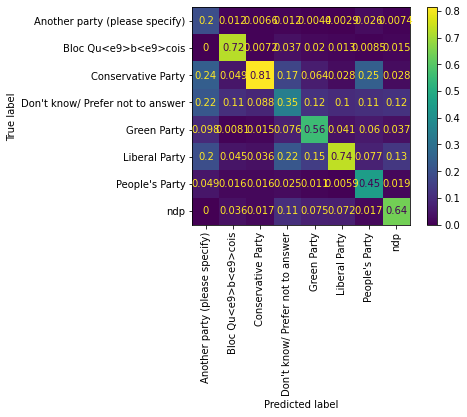

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.20      0.16      0.18        49
            Bloc Qu<e9>b<e9>cois       0.72      0.67      0.70       268
              Conservative Party       0.81      0.82      0.82      1657
Don't know/ Prefer not to answer       0.35      0.38      0.36       827
                     Green Party       0.56      0.55      0.55       459
                   Liberal Party       0.74      0.73      0.73      1711
                  People's Party       0.45      0.38      0.42       138
                             ndp       0.64      0.64      0.64       812

                        accuracy                           0.66      5921
                       macro avg       0.56      0.54      0.55      5921
                    weighted avg       0.67      0.66      0.66      5921



2) 'cps19_fed_id' x 'cps19_lead_rating*':

In [ ]:
cat_tokeep = data_text['cps19_fed_id'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_lead_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb2 = data_comb['cps19_votechoice']
feats_comb2 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb2 = pd.DataFrame(scaler.fit_transform(feats_comb2), 
                           columns = feats_comb2.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb2, labels_comb2, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

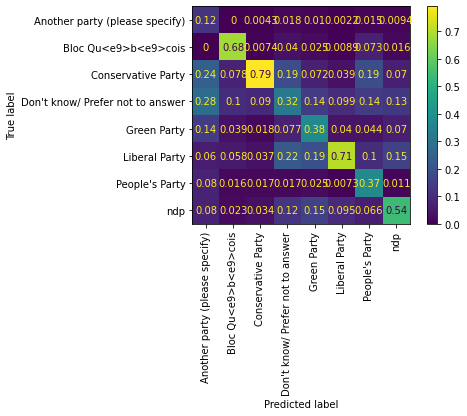

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.12      0.13      0.12        46
            Bloc Qu<e9>b<e9>cois       0.68      0.65      0.67       271
              Conservative Party       0.79      0.78      0.78      1660
Don't know/ Prefer not to answer       0.32      0.32      0.32       810
                     Green Party       0.38      0.44      0.41       425
                   Liberal Party       0.71      0.72      0.72      1749
                  People's Party       0.37      0.38      0.38       133
                             ndp       0.54      0.49      0.51       823

                        accuracy                           0.62      5917
                       macro avg       0.49      0.49      0.49      5917
                    weighted avg       0.62      0.62      0.62      5917



3) 'cps19_fed_id' x 'cps19_cand_rating*':

In [ ]:
cat_tokeep = data_text['cps19_fed_id'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb3 = data_comb['cps19_votechoice']
feats_comb3 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb3 = pd.DataFrame(scaler.fit_transform(feats_comb3), 
                           columns = feats_comb3.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb3, labels_comb3, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

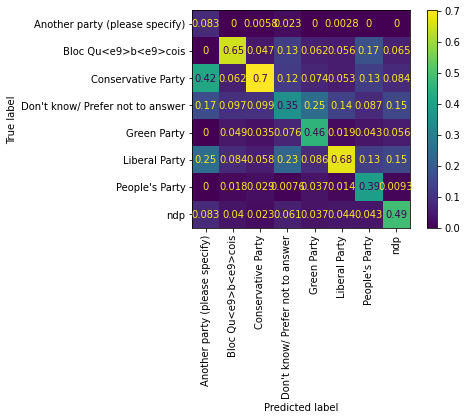

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.08      0.17      0.11         6
            Bloc Qu<e9>b<e9>cois       0.65      0.71      0.68       208
              Conservative Party       0.70      0.62      0.66       192
Don't know/ Prefer not to answer       0.35      0.26      0.30       174
                     Green Party       0.46      0.47      0.47        78
                   Liberal Party       0.68      0.73      0.70       331
                  People's Party       0.39      0.32      0.35        28
                             ndp       0.49      0.55      0.52        94

                        accuracy                           0.59      1111
                       macro avg       0.47      0.48      0.47      1111
                    weighted avg       0.58      0.59      0.58      1111



4) 'cps19_vote_2015' x 'cps19_party_rating*':

In [ ]:
cat_tokeep = data_text['cps19_vote_2015'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb4 = data_comb['cps19_votechoice']
feats_comb4 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb4 = pd.DataFrame(scaler.fit_transform(feats_comb4), 
                           columns = feats_comb4.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb4, labels_comb4, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

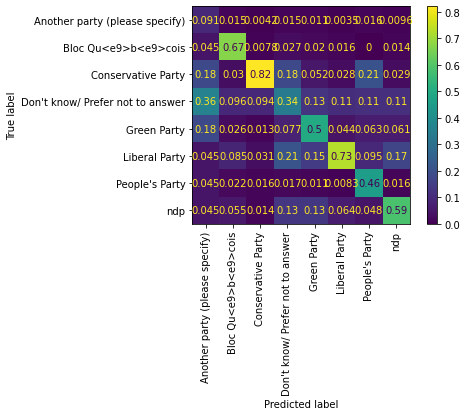

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.09      0.08      0.09        49
            Bloc Qu<e9>b<e9>cois       0.67      0.68      0.68       268
              Conservative Party       0.82      0.83      0.82      1657
Don't know/ Prefer not to answer       0.34      0.35      0.34       827
                     Green Party       0.50      0.49      0.50       459
                   Liberal Party       0.73      0.72      0.73      1711
                  People's Party       0.46      0.42      0.44       138
                             ndp       0.59      0.60      0.59       812

                        accuracy                           0.65      5921
                       macro avg       0.53      0.52      0.52      5921
                    weighted avg       0.65      0.65      0.65      5921



5) 'cps19_vote_2015' x 'cps19_lead_rating*':

In [ ]:
cat_tokeep = data_text['cps19_vote_2015'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_lead_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb5 = data_comb['cps19_votechoice']
feats_comb5 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb5 = pd.DataFrame(scaler.fit_transform(feats_comb5), 
                           columns = feats_comb5.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb5, labels_comb5, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

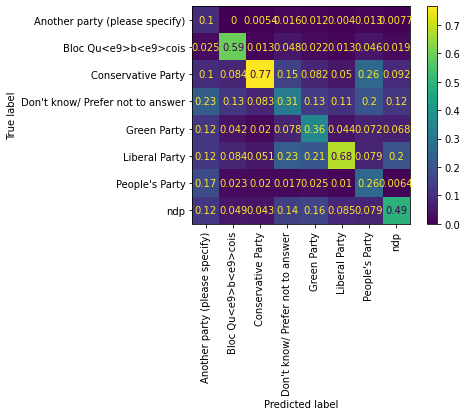

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.10      0.09      0.09        46
            Bloc Qu<e9>b<e9>cois       0.59      0.58      0.58       271
              Conservative Party       0.77      0.77      0.77      1660
Don't know/ Prefer not to answer       0.31      0.30      0.31       810
                     Green Party       0.36      0.41      0.38       425
                   Liberal Party       0.68      0.68      0.68      1749
                  People's Party       0.26      0.29      0.27       133
                             ndp       0.49      0.47      0.48       823

                        accuracy                           0.59      5917
                       macro avg       0.44      0.45      0.45      5917
                    weighted avg       0.59      0.59      0.59      5917



6) 'cps19_vote_2015' x 'cps19_cand_rating*':

In [ ]:
cat_tokeep = data_text['cps19_vote_2015'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb6 = data_comb['cps19_votechoice']
feats_comb6 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb6 = pd.DataFrame(scaler.fit_transform(feats_comb6), 
                           columns = feats_comb6.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb6, labels_comb6, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

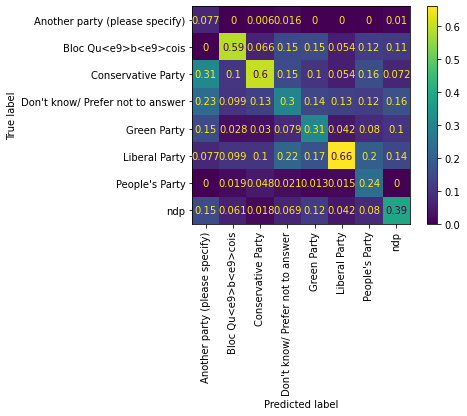

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.08      0.17      0.11         6
            Bloc Qu<e9>b<e9>cois       0.59      0.60      0.60       208
              Conservative Party       0.60      0.52      0.56       192
Don't know/ Prefer not to answer       0.30      0.32      0.31       174
                     Green Party       0.31      0.31      0.31        78
                   Liberal Party       0.66      0.66      0.66       331
                  People's Party       0.24      0.21      0.23        28
                             ndp       0.39      0.40      0.40        94

                        accuracy                           0.51      1111
                       macro avg       0.40      0.40      0.40      1111
                    weighted avg       0.52      0.51      0.51      1111



7) 'cps19_imp_iss_party' x 'cps19_party_rating*':

In [ ]:
cat_tokeep = data_text['cps19_imp_iss_party'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb7 = data_comb['cps19_votechoice']
feats_comb7 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb7 = pd.DataFrame(scaler.fit_transform(feats_comb7), 
                           columns = feats_comb7.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb7, labels_comb7, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

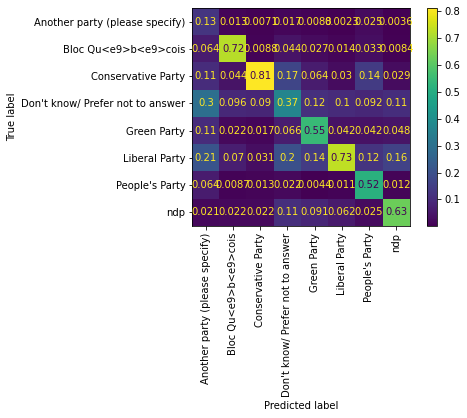

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.13      0.12      0.12        49
            Bloc Qu<e9>b<e9>cois       0.72      0.62      0.67       268
              Conservative Party       0.81      0.83      0.82      1657
Don't know/ Prefer not to answer       0.37      0.37      0.37       827
                     Green Party       0.55      0.54      0.54       459
                   Liberal Party       0.73      0.73      0.73      1711
                  People's Party       0.52      0.45      0.48       138
                             ndp       0.63      0.65      0.64       812

                        accuracy                           0.67      5921
                       macro avg       0.56      0.54      0.55      5921
                    weighted avg       0.67      0.67      0.67      5921



8) 'cps19_imp_iss_party' x 'cps19_lead_rating*':

In [ ]:
cat_tokeep = data_text['cps19_imp_iss_party'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_lead_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb8 = data_comb['cps19_votechoice']
feats_comb8 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb8 = pd.DataFrame(scaler.fit_transform(feats_comb8), 
                           columns = feats_comb8.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb5, labels_comb5, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

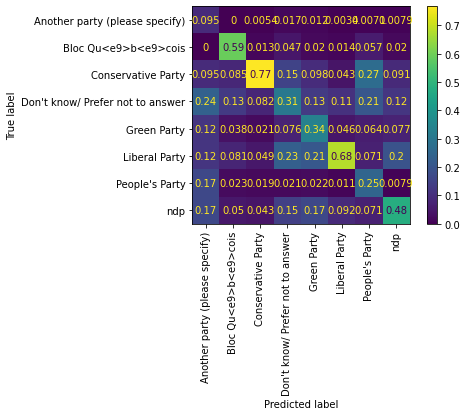

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.10      0.09      0.09        46
            Bloc Qu<e9>b<e9>cois       0.59      0.57      0.58       271
              Conservative Party       0.77      0.77      0.77      1660
Don't know/ Prefer not to answer       0.31      0.31      0.31       810
                     Green Party       0.34      0.39      0.36       425
                   Liberal Party       0.68      0.68      0.68      1749
                  People's Party       0.25      0.26      0.26       133
                             ndp       0.48      0.44      0.46       823

                        accuracy                           0.58      5917
                       macro avg       0.44      0.44      0.44      5917
                    weighted avg       0.58      0.58      0.58      5917



9) 'cps19_imp_iss_party' x 'cps19_cand_rating*':

In [ ]:
cat_tokeep = data_text['cps19_imp_iss_party'].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb9 = data_comb['cps19_votechoice']
feats_comb9 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb9 = pd.DataFrame(scaler.fit_transform(feats_comb9), 
                           columns = feats_comb9.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb6, labels_comb6, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

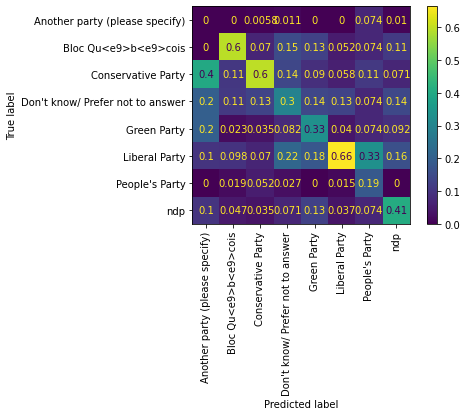

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.00      0.00      0.00         6
            Bloc Qu<e9>b<e9>cois       0.60      0.62      0.61       208
              Conservative Party       0.60      0.54      0.57       192
Don't know/ Prefer not to answer       0.30      0.31      0.30       174
                     Green Party       0.33      0.33      0.33        78
                   Liberal Party       0.66      0.66      0.66       331
                  People's Party       0.19      0.18      0.18        28
                             ndp       0.41      0.43      0.42        94

                        accuracy                           0.52      1111
                       macro avg       0.39      0.38      0.38      1111
                    weighted avg       0.52      0.52      0.52      1111



**La meilleure paire est 'cps19_fed_id' x 'cps19_party_rating', mais 'cps19_imp_iss_party' x 'cps19_party_rating' est pratiquement aussi performante**

Est-ce que l'ajout des autres attributs catégoriques peut améliorer le modèle?

1) 'cps19_vote_2015':

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_vote_2015']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb10 = data_comb['cps19_votechoice']
feats_comb10 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb10 = pd.DataFrame(scaler.fit_transform(feats_comb10), 
                           columns = feats_comb10.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb10, labels_comb10, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

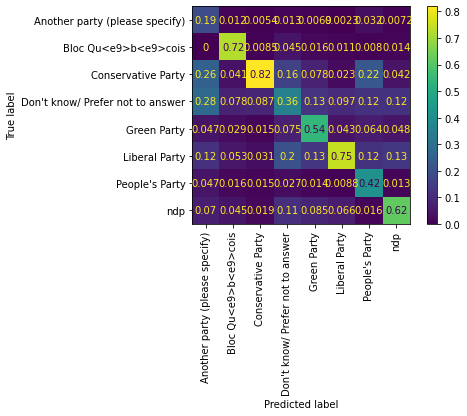

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.19      0.16      0.17        49
            Bloc Qu<e9>b<e9>cois       0.72      0.66      0.69       268
              Conservative Party       0.82      0.82      0.82      1657
Don't know/ Prefer not to answer       0.36      0.38      0.37       827
                     Green Party       0.54      0.51      0.53       459
                   Liberal Party       0.75      0.75      0.75      1711
                  People's Party       0.42      0.38      0.40       138
                             ndp       0.62      0.63      0.63       812

                        accuracy                           0.66      5921
                       macro avg       0.55      0.54      0.54      5921
                    weighted avg       0.67      0.66      0.67      5921



2) 'cps19_imp_iss_party':

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb11 = data_comb['cps19_votechoice']
feats_comb11 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb11 = pd.DataFrame(scaler.fit_transform(feats_comb11), 
                           columns = feats_comb11.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb11, labels_comb11, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

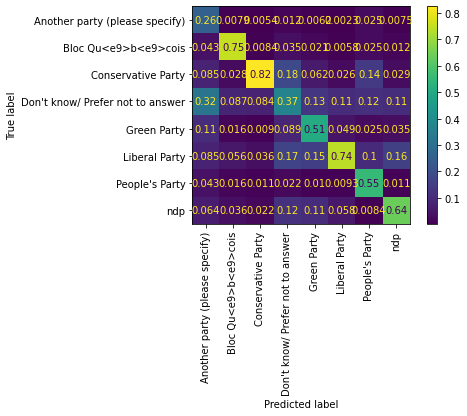

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.26      0.24      0.25        49
            Bloc Qu<e9>b<e9>cois       0.75      0.71      0.73       268
              Conservative Party       0.82      0.83      0.83      1657
Don't know/ Prefer not to answer       0.37      0.37      0.37       827
                     Green Party       0.51      0.54      0.52       459
                   Liberal Party       0.74      0.75      0.75      1711
                  People's Party       0.55      0.48      0.51       138
                             ndp       0.64      0.63      0.64       812

                        accuracy                           0.67      5921
                       macro avg       0.58      0.57      0.57      5921
                    weighted avg       0.67      0.67      0.67      5921



L'attribut 'cps19_imp_iss_party' améliore bel et bien le modèle.

Et les trois attributs ensemble?

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb12 = data_comb['cps19_votechoice']
feats_comb12 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb12 = pd.DataFrame(scaler.fit_transform(feats_comb12), 
                           columns = feats_comb12.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb12, labels_comb12, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

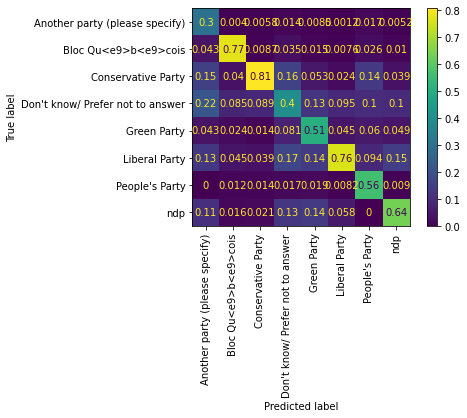

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.30      0.29      0.29        49
            Bloc Qu<e9>b<e9>cois       0.77      0.71      0.74       268
              Conservative Party       0.81      0.84      0.82      1657
Don't know/ Prefer not to answer       0.40      0.40      0.40       827
                     Green Party       0.51      0.52      0.51       459
                   Liberal Party       0.76      0.76      0.76      1711
                  People's Party       0.56      0.48      0.52       138
                             ndp       0.64      0.61      0.62       812

                        accuracy                           0.68      5921
                       macro avg       0.59      0.58      0.58      5921
                    weighted avg       0.68      0.68      0.68      5921



Encore mieux! Il semble que la combinaison de ces trois attributs étaient judicieuse.

Et si on essaie d'ajouter les autres séries de ratings numériques?

1) 'cps19_lead_rating'

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_lead_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb13 = data_comb['cps19_votechoice']
feats_comb13 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb13 = pd.DataFrame(scaler.fit_transform(feats_comb13), 
                           columns = feats_comb13.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb13, labels_comb13, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

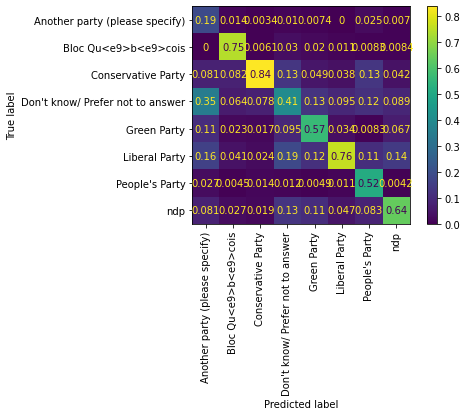

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.19      0.21      0.20        33
            Bloc Qu<e9>b<e9>cois       0.75      0.73      0.74       224
              Conservative Party       0.84      0.84      0.84      1461
Don't know/ Prefer not to answer       0.41      0.40      0.40       682
                     Green Party       0.57      0.54      0.55       425
                   Liberal Party       0.76      0.77      0.77      1452
                  People's Party       0.52      0.54      0.53       114
                             ndp       0.64      0.65      0.64       707

                        accuracy                           0.69      5098
                       macro avg       0.58      0.59      0.58      5098
                    weighted avg       0.69      0.69      0.69      5098



Pas vraiment d'amélioration...

2) 'cps19_cand_rating'

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb14 = data_comb['cps19_votechoice']
feats_comb14 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb14 = pd.DataFrame(scaler.fit_transform(feats_comb14), 
                            columns = feats_comb14.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb14, labels_comb14, test_size = 0.25, random_state = 42)

In [ ]:
Tree = DecisionTreeClassifier(class_weight='balanced')
Tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight='balanced')

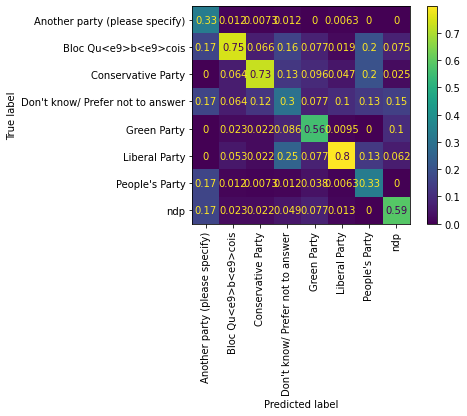

In [ ]:
ConfusionMatrixDisplay.from_estimator(Tree, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Tree.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.33      0.22      0.27         9
            Bloc Qu<e9>b<e9>cois       0.75      0.70      0.72       183
              Conservative Party       0.73      0.64      0.68       157
Don't know/ Prefer not to answer       0.30      0.38      0.33       127
                     Green Party       0.56      0.48      0.51        61
                   Liberal Party       0.80      0.80      0.80       316
                  People's Party       0.33      0.33      0.33        15
                             ndp       0.59      0.66      0.62        71

                        accuracy                           0.65       939
                       macro avg       0.55      0.53      0.53       939
                    weighted avg       0.67      0.65      0.66       939



Cette fois, on réduit clairement la performance. La meilleure combinaison "minimale" est donc celle identifiée précédemment!

Pour un RandomForest avec une grande profondeur, la combinaison des attributs numériques semble utile. Essayons d'ajouter les trois séries:

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_cand_rating*|cps19_lead_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.drop('cps19_cand_rating_26', axis=1) #Droppée car trop de NaN
data_comb = data_comb.dropna()

In [ ]:
labels_comb15 = data_comb['cps19_votechoice']
feats_comb15 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb15 = pd.DataFrame(scaler.fit_transform(feats_comb15), 
                            columns = feats_comb15.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb15, labels_comb15, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample',
                                n_estimators=200, max_depth=31)
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=31,
                       n_estimators=200)

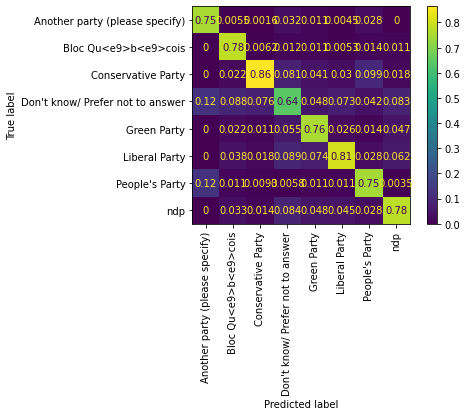

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.75      0.19      0.31        31
            Bloc Qu<e9>b<e9>cois       0.78      0.83      0.80       171
              Conservative Party       0.86      0.92      0.89      1214
Don't know/ Prefer not to answer       0.64      0.45      0.53       498
                     Green Party       0.76      0.67      0.71       303
                   Liberal Party       0.81      0.90      0.85      1185
                  People's Party       0.75      0.60      0.66        89
                             ndp       0.78      0.78      0.78       569

                        accuracy                           0.80      4060
                       macro avg       0.77      0.67      0.69      4060
                    weighted avg       0.79      0.80      0.79      4060



La combinaison des trois séries est meilleure, mais le gain est quelque peu limité. Peut-on faire mieux avec la meilleure paire?

1) party_rating avec lead_rating

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_lead_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb16 = data_comb['cps19_votechoice']
feats_comb16 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb16 = pd.DataFrame(scaler.fit_transform(feats_comb16), 
                            columns = feats_comb16.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb16, labels_comb16, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample',
                                n_estimators=200, max_depth=31)
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=31,
                       n_estimators=200)

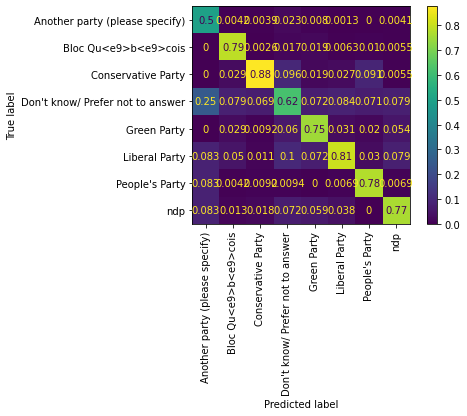

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.50      0.18      0.27        33
            Bloc Qu<e9>b<e9>cois       0.79      0.84      0.82       224
              Conservative Party       0.88      0.92      0.90      1461
Don't know/ Prefer not to answer       0.62      0.49      0.55       682
                     Green Party       0.75      0.66      0.70       425
                   Liberal Party       0.81      0.88      0.84      1452
                  People's Party       0.78      0.68      0.72       114
                             ndp       0.77      0.79      0.78       707

                        accuracy                           0.80      5098
                       macro avg       0.74      0.68      0.70      5098
                    weighted avg       0.79      0.80      0.79      5098



2) party_rating avec cand_rating

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.drop('cps19_cand_rating_26', axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb17 = data_comb['cps19_votechoice']
feats_comb17 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb17 = pd.DataFrame(scaler.fit_transform(feats_comb17), 
                            columns = feats_comb17.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb17, labels_comb17, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample',
                                n_estimators=200, max_depth=31)
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=31,
                       n_estimators=200)

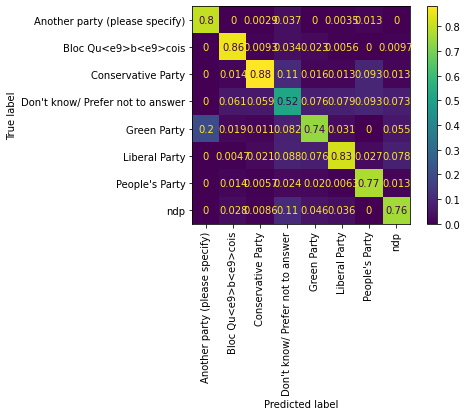

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.80      0.14      0.24        28
            Bloc Qu<e9>b<e9>cois       0.86      0.80      0.83       230
              Conservative Party       0.88      0.94      0.91      1316
Don't know/ Prefer not to answer       0.52      0.41      0.46       478
                     Green Party       0.74      0.63      0.68       356
                   Liberal Party       0.83      0.90      0.86      1314
                  People's Party       0.77      0.57      0.66       101
                             ndp       0.76      0.79      0.77       593

                        accuracy                           0.80      4416
                       macro avg       0.77      0.65      0.68      4416
                    weighted avg       0.79      0.80      0.79      4416



C'est très similaire à la combinaison des trois attributs, et peut-être même un peu meilleur!

Deux des trois séries semblent donc donner les meilleurs résultats!

Essayons d'ajouter l'âge et l'intérêt envers l'élection:

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]
data_age = data_num[['cps19_age', 'cps19_interest_elxn_1']]

data_comb = pd.concat([cat_tokeep, data_party, data_age, 
                       vote_int['cps19_votechoice']], axis=1)
data_comb = data_comb.drop('cps19_cand_rating_26', axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb18 = data_comb['cps19_votechoice']
feats_comb18 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb18 = pd.DataFrame(scaler.fit_transform(feats_comb18), 
                            columns = feats_comb18.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb18, labels_comb18, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample',
                                n_estimators=200, max_depth=43)
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=43,
                       n_estimators=200)

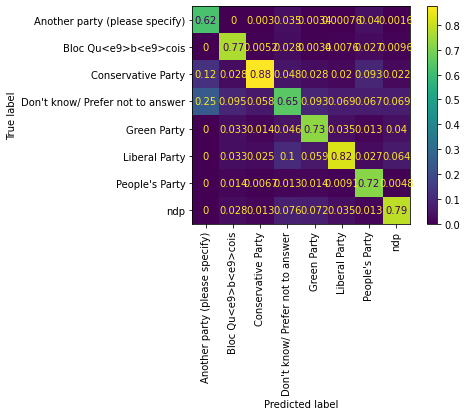

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       0.62      0.17      0.27        29
            Bloc Qu<e9>b<e9>cois       0.77      0.81      0.79       199
              Conservative Party       0.88      0.94      0.90      1264
Don't know/ Prefer not to answer       0.65      0.49      0.56       524
                     Green Party       0.73      0.65      0.68       327
                   Liberal Party       0.82      0.89      0.85      1228
                  People's Party       0.72      0.60      0.65        90
                             ndp       0.79      0.80      0.80       614

                        accuracy                           0.81      4275
                       macro avg       0.75      0.67      0.69      4275
                    weighted avg       0.80      0.81      0.80      4275



Malgré une augmentation de la profondeur des arbres, la performance n'est pas vraiment améliorée.

Essayons d'inclure la satisfaction envers le gouvernement sortant:

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015', 'cps19_fed_gov_sat']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.drop('cps19_cand_rating_26', axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb19 = data_comb['cps19_votechoice']
feats_comb19 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb19 = pd.DataFrame(scaler.fit_transform(feats_comb19), 
                            columns = feats_comb19.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb19, labels_comb19, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample',
                                n_estimators=200, max_depth=33)
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=33,
                       n_estimators=200)

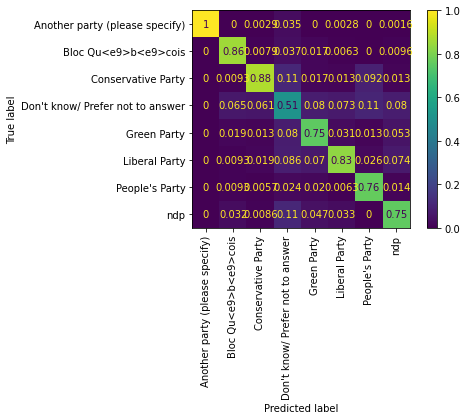

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       1.00      0.21      0.35        28
            Bloc Qu<e9>b<e9>cois       0.86      0.80      0.83       230
              Conservative Party       0.88      0.94      0.91      1316
Don't know/ Prefer not to answer       0.51      0.40      0.45       478
                     Green Party       0.75      0.63      0.69       356
                   Liberal Party       0.83      0.90      0.87      1314
                  People's Party       0.76      0.57      0.66       101
                             ndp       0.75      0.79      0.77       593

                        accuracy                           0.81      4416
                       macro avg       0.79      0.66      0.69      4416
                    weighted avg       0.80      0.81      0.80      4416



Essayons un autre modèle incluant aussi 'cps19_issue_handle_8' (utile pour le PPC):

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015', 'cps19_fed_gov_sat',
                        'cps19_issue_handle_8']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.drop('cps19_cand_rating_26', axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb20 = data_comb['cps19_votechoice']
feats_comb20 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb20 = pd.DataFrame(scaler.fit_transform(feats_comb20), 
                            columns = feats_comb20.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb20, labels_comb20, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample',
                                n_estimators=200, max_depth=34)
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=34,
                       n_estimators=200)

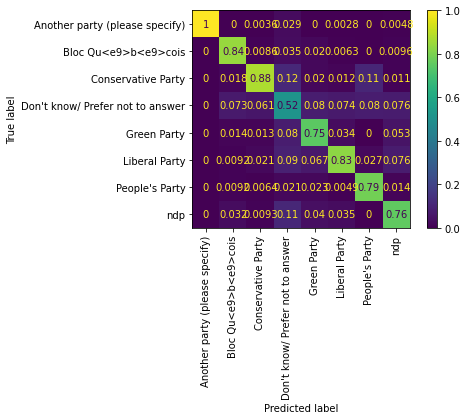

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       1.00      0.18      0.30        28
            Bloc Qu<e9>b<e9>cois       0.84      0.80      0.82       230
              Conservative Party       0.88      0.93      0.90      1316
Don't know/ Prefer not to answer       0.52      0.41      0.45       478
                     Green Party       0.75      0.63      0.68       356
                   Liberal Party       0.83      0.90      0.86      1314
                  People's Party       0.79      0.58      0.67       101
                             ndp       0.76      0.79      0.77       593

                        accuracy                           0.80      4416
                       macro avg       0.79      0.65      0.68      4416
                    weighted avg       0.79      0.80      0.79      4416



Cela ne semble pas aider. Et si on ajoute plutôt 'cps19_issue_handle_2?

In [ ]:
cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015', 'cps19_fed_gov_sat',
                        'cps19_issue_handle_2']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, vote_int['cps19_votechoice']],
                      axis=1)
data_comb = data_comb.drop('cps19_cand_rating_26', axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb21 = data_comb['cps19_votechoice']
feats_comb21 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb21 = pd.DataFrame(scaler.fit_transform(feats_comb21), 
                            columns = feats_comb21.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb21, labels_comb21, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample',
                                n_estimators=200, max_depth=34)
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=34,
                       n_estimators=200)

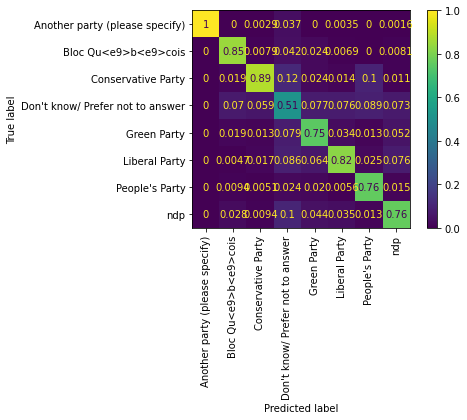

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       1.00      0.14      0.25        28
            Bloc Qu<e9>b<e9>cois       0.85      0.79      0.82       230
              Conservative Party       0.89      0.93      0.91      1316
Don't know/ Prefer not to answer       0.51      0.41      0.46       478
                     Green Party       0.75      0.62      0.68       356
                   Liberal Party       0.82      0.90      0.86      1314
                  People's Party       0.76      0.59      0.67       101
                             ndp       0.76      0.79      0.78       593

                        accuracy                           0.80      4416
                       macro avg       0.79      0.65      0.68      4416
                    weighted avg       0.80      0.80      0.79      4416



Cela ne semble pas offrir d'amélioration non plus.

Dernière tentative: Ajout de la série 'leader_cares'

In [ ]:
mask_onehot = one_hot_df.columns.str.contains(r'cps19_lead_cares*')
data_cares = one_hot_df.loc[:, mask_onehot]

cat_tokeep = data_text[['cps19_fed_id', 'cps19_imp_iss_party',
                        'cps19_vote_2015', 'cps19_fed_gov_sat',
                        'cps19_issue_handle_2']].copy()
cat_tokeep = pd.get_dummies(cat_tokeep)

mask_model = data_num.columns.str.contains(r'cps19_party_rating*|cps19_cand_rating*')
data_party = data_num.loc[:, mask_model]

data_comb = pd.concat([cat_tokeep, data_party, data_cares, 
                       vote_int['cps19_votechoice']], axis=1)
data_comb = data_comb.drop('cps19_cand_rating_26', axis=1)
data_comb = data_comb.dropna()

In [ ]:
labels_comb22 = data_comb['cps19_votechoice']
feats_comb22 = data_comb.drop('cps19_votechoice', axis=1)

feats_comb22 = pd.DataFrame(scaler.fit_transform(feats_comb22), 
                            columns = feats_comb22.columns)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(feats_comb22, labels_comb22, test_size = 0.25, random_state = 42)

In [ ]:
Forest = RandomForestClassifier(class_weight='balanced_subsample',
                                n_estimators=200, max_depth=35)
Forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=35,
                       n_estimators=200)

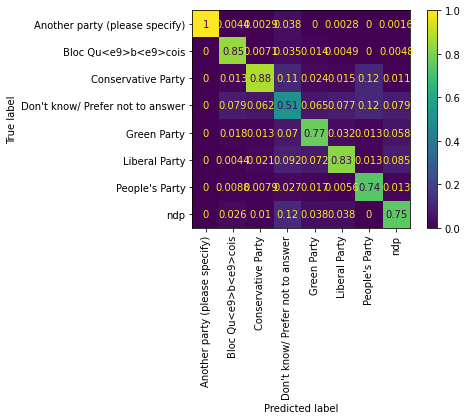

In [ ]:
ConfusionMatrixDisplay.from_estimator(Forest, test_features, 
                                      test_labels, normalize='pred', 
                                      xticks_rotation='vertical')

In [ ]:
preds = Forest.predict(test_features)

print(classification_report(test_labels, preds))

                                  precision    recall  f1-score   support

  Another party (please specify)       1.00      0.14      0.25        28
            Bloc Qu<e9>b<e9>cois       0.85      0.84      0.84       230
              Conservative Party       0.88      0.93      0.90      1316
Don't know/ Prefer not to answer       0.51      0.39      0.44       478
                     Green Party       0.77      0.63      0.70       356
                   Liberal Party       0.83      0.89      0.86      1314
                  People's Party       0.74      0.56      0.64       101
                             ndp       0.75      0.78      0.76       593

                        accuracy                           0.80      4416
                       macro avg       0.79      0.65      0.67      4416
                    weighted avg       0.79      0.80      0.79      4416



Cela ne semble pas améliorer les prédictions non plus